In [1]:
import numpy as np
import jax
import jax.numpy as jnp

from deep_parity.jax.model import Perceptron
from deep_parity.jax.boolean_cube import fourier_transform, generate_all_binary_arrays

from pathlib import Path

import polars as pl
from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs

from google.cloud import storage
import equinox as eqx


def try_load_checkpoint(model_template, bucket_name, config, step):
    """Try to load the latest checkpoint from GCS bucket"""
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    
    # Find checkpoints
    n = config['model']['n']
    seed = config['seed']
    model_dim = config['model']['model_dim']
    checkpoint_dir = f"full/one-layer/model_dim={model_dim}/n={n}/seed={seed}"
    blobs = list(bucket.list_blobs(prefix=f"{checkpoint_dir}/model_"))
    
    if not blobs:
        print("No checkpoints found, starting fresh training")
        return None
    
   
    
    # Download latest checkpoint files
    model_blob = bucket.blob(f"{checkpoint_dir}/model_{step}.eqx")
    model_local_path = f"/tmp/model_{step}.eqx"
    model_blob.download_to_filename(model_local_path)
    
    #opt_blob = bucket.blob(f"{checkpoint_dir}/opt_{latest_step}.eqx")
    #opt_local_path = f"/tmp/opt_{latest_step}.eqx"
    #opt_blob.download_to_filename(opt_local_path)
    
    #rng_blob = bucket.blob(f"{checkpoint_dir}/rng_{latest_step}.eqx")
    #rng_local_path = f"/tmp/rng_{latest_step}.npy"
    #try:
    #    rng_blob.download_to_filename(rng_local_path)
    #except:
    #    # If RNG file doesn't exist, create a new key
    #    print("RNG key not found, creating new one")
    #    rng_key = jax.random.PRNGKey(config['seed'])
    #else:
    #    with open(rng_local_path, "rb") as f:
    #        rng_key = np.load(f)
    
    # Deserialize model and optimizer state
    model = eqx.tree_deserialise_leaves(model_local_path, model_template)
    
    # Initialize optimizer state with the model template to get the structure
    #dummy_opt_state = optimizer.init(eqx.filter(model_template, eqx.is_inexact_array))
    #opt_state = eqx.tree_deserialise_leaves(opt_local_path, dummy_opt_state)
    
    return model





In [2]:
n = 20
model_dim = 128
step = 30_000
seed = 0

config = {'model': {'n': n, 'model_dim': model_dim}, 'seed': seed}

bucket_name = "deep-parity-training-0"

key = jax.random.key(0)

template = Perceptron(n, model_dim, key)

model = try_load_checkpoint(template, bucket_name, config, step)




In [13]:
model.linear.weight.shape

(128, 20)

In [26]:
import random

idx = random.randint(0, 128)
w = model.linear.weight[idx]
min_val = jnp.abs(w).min()
sorted_inds = jnp.argsort(jnp.abs(w))

w[sorted_inds] / min_val

Array([-1.       ,  1.0000001, -1.0000001, -1.0000001,  1.0000001,
        1.0000001, -1.0000001, -1.0000002,  1.0000002,  1.0000002,
       -1.0000004,  1.0000018, -1.0002855,  1.0019981,  1.0023549,
        1.0027355, -1.003263 ,  1.0041237,  1.0041237, -2.9985979],      dtype=float32)

In [49]:
import optax


def generate_boolean_cube(n: int):
    return np.sign(-1. * (generate_all_binary_arrays(n) - 0.5).astype(float))


def compute_loss(model, batch_x, batch_y):
    pred = model(batch_x)
    
    targets_one_hot = jax.nn.one_hot(
        (batch_y == 1.).astype(int),
        num_classes=2
    )
    
    per_example_loss = optax.softmax_cross_entropy(
        pred,
        targets_one_hot
    )
    
    # Compute entropy of predictions
    
    losses = jnp.mean(per_example_loss, axis=0)
    return jnp.mean(losses)




cube = generate_boolean_cube(n)
parities = cube.prod(axis=-1)

Array(0.00364871, dtype=float32)

In [ ]:
x = jnp.expand_dims(boolean_cube[1], axis=0)
y = x.prod(axis=-1)


model_grads = jax.grad(compute_loss)(model, x, y)

from jax import jvp, grad

# forward-over-reverse
def hvp(model, x, y, tangents):
    def f(model):
        return compute_loss(model, x, y)
    return eqx.filter_jvp(eqx.filter_grad(f), model, tangents)[1]


key, subkey = jax.random.split(key)

randvecs = jax.tree.map(lambda x: jax.random.normal(subkey, shape=x.shape), eqx.filter(model_grads, eqx.is_array))


In [28]:

def integer_proximity(numbers):
    # Calculate distance to nearest integer for each number
    distances = jnp.abs(jnp.round(numbers) - numbers)
    
    # Various metrics
    mean_distance = jnp.mean(distances, axis=1)
    rms_distance = jnp.sqrt(jnp.mean(jnp.square(distances), axis=1))
    max_distance = jnp.max(distances, axis=1)
    
    return {
        "mean_distance": mean_distance,
        "rms_distance": rms_distance,
        "max_distance": max_distance
    }


def max_min_ratio(tensor):
    max_val = jnp.abs(tensor).max(axis=1)
    min_val = jnp.abs(tensor).min(axis=1)
    return max_val / min_val



In [29]:


max_min_ratio(model.linear.weight)

Array([1.36076832e+01, 1.01089907e+00, 1.13628280e+00, 1.34055436e+00,
       2.62818604e+01, 1.00196207e+00, 3.00700688e+00, 2.28723907e+00,
       1.07678652e+00, 1.02928388e+00, 5.99805593e+00, 1.00488997e+00,
       1.02166009e+00, 7.25832367e+01, 1.20441580e+00, 1.01204538e+00,
       3.00331140e+00, 2.99916077e+00, 1.00456345e+00, 3.03349257e+00,
       5.11625195e+00, 1.01846135e+00, 1.20593655e+00, 1.00873601e+00,
       3.03239632e+00, 3.02076912e+00, 1.13607240e+00, 5.06811810e+00,
       1.02317607e+00, 5.01338577e+00, 1.00404048e+00, 3.02855945e+00,
       1.00950539e+00, 9.99937820e+00, 1.01065922e+00, 5.05198622e+00,
       1.01152742e+00, 3.02200413e+00, 1.02038729e+00, 9.05193996e+00,
       1.03855538e+00, 1.02810299e+00, 1.01784790e+00, 1.01207399e+00,
       5.23950386e+00, 1.08833275e+01, 1.00235491e+01, 5.01267242e+00,
       1.00871515e+00, 1.00399196e+00, 1.06735241e+00, 5.09424734e+00,
       1.12624383e+00, 1.71898508e+00, 1.01238036e+00, 1.02863967e+00,
      

In [30]:
data = []
steps = list(range(0, 2000, 20)) + list(range(1000, 30001, 1000))
for seed in range(8):
    config['seed'] = seed
    for step in steps:
        model = try_load_checkpoint(template, bucket_name, config, step)
        ckpt_data = np.array(max_min_ratio(model.linear.weight))
        df = pl.DataFrame({'max_min_ratio': ckpt_data})
        df = df.with_columns(step=pl.lit(step), seed=pl.lit(seed)).with_row_index()
        data.append(df)

weight_df = pl.concat(data, how='vertical').unpivot(index=['step', 'seed', 'index'])

/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


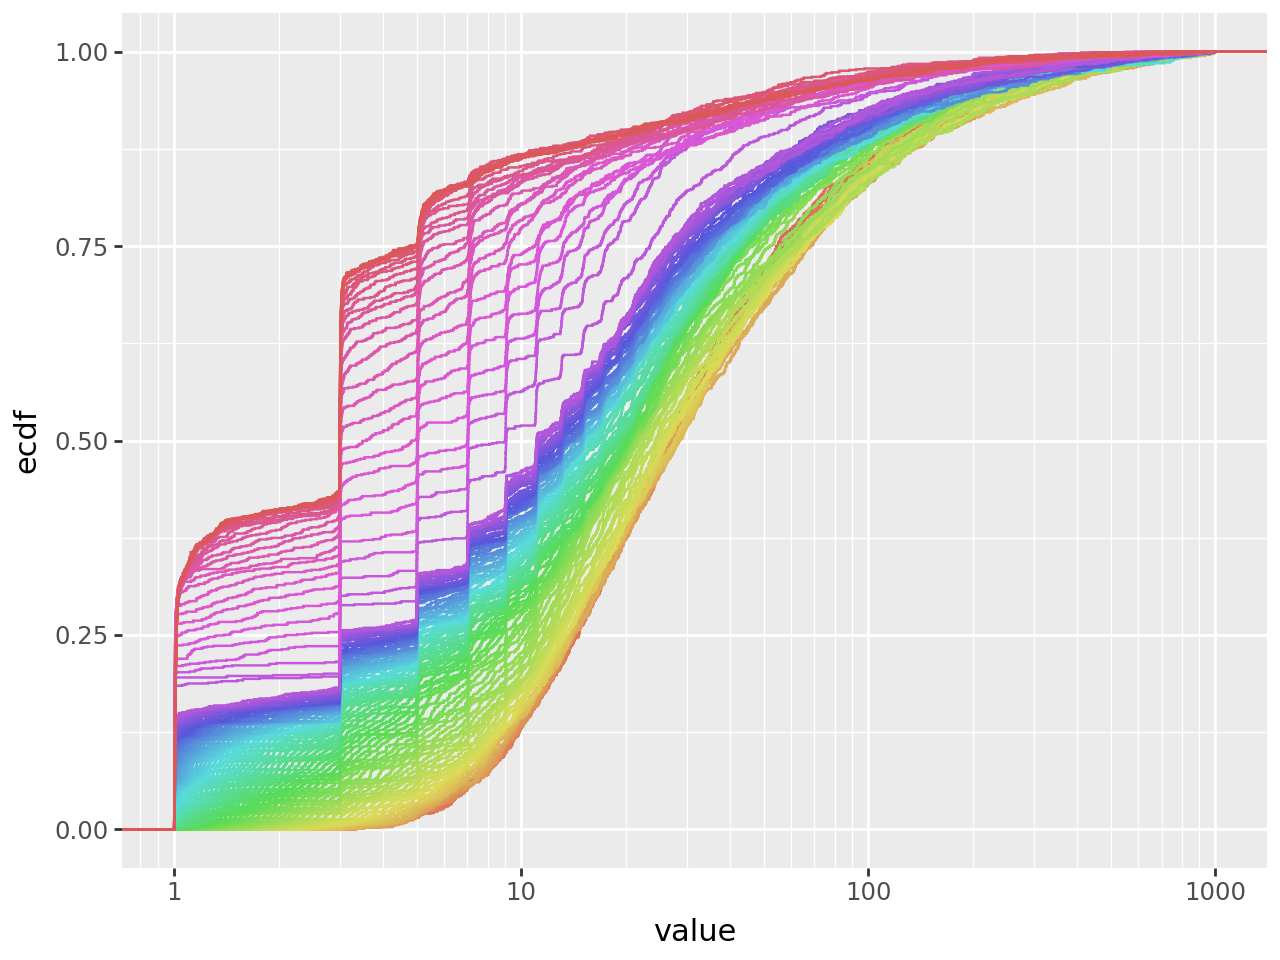

In [41]:
from plotnine import ggplot, aes, theme, labs, geom_histogram, facet_wrap, stat_ecdf, scale_x_log10
df = weight_df.filter(pl.col('value').le(1000))

ggplot(df, aes(x='value', color='factor(step)')) + stat_ecdf(show_legend=False) + scale_x_log10()

In [48]:
from jax.nn import relu


class Perceptron(eqx.Module):
    linear: eqx.Module
    unembed: eqx.Module

    def __init__(self, n: int, model_dim: int, key, use_bias=True):
        linear_key, unembed_key = jax.random.split(key)
        self.linear = eqx.nn.Linear(in_features=n, out_features=model_dim, use_bias=use_bias, key=linear_key)
        self.unembed = eqx.nn.Linear(in_features=model_dim, out_features=2, use_bias=False, key=unembed_key)
    
    def __call__(self, x):
        preactivations = self.linear(x)
        outputs = self.unembed(relu(preactivations))
        return outputs


n = 20
model_dim = 128
step = 30_000
seed = 0

config = {'model': {'n': n, 'model_dim': model_dim}, 'seed': seed}

bucket_name = "deep-parity-training-0"

key = jax.random.key(0)

template = Perceptron(n, model_dim, key)

model = try_load_checkpoint(template, bucket_name, config, step)


cube = generate_boolean_cube(n)
parities = cube.prod(axis=1)

In [52]:
def compute_loss(model, batch_x, batch_y):
    pred = model(batch_x)
    
    targets_one_hot = jax.nn.one_hot(
        (batch_y == 1.).astype(int),
        num_classes=2
    )
    
    loss = optax.softmax_cross_entropy(
        pred,
        targets_one_hot
    )
    
    # Compute entropy of predictions
    return loss
    
compute_loss(model, cube[1], parities[1])

Array(0.00364871, dtype=float32)

In [53]:
import equinox as eqx
from functools import partial
import jax
import jax.numpy as jnp
from jax.nn import relu
from jax.sharding import PartitionSpec as P
from jax.experimental import mesh_utils



@jax.jit
def outerproduct(grad_triplet):
    """
    Compute the outer products of gradient matrices.
    
    Args:
        grad_triplet: A tuple of three matrices (mat1, mat2, mat3)
    
    Returns:
        List of outer products between all pairs of matrices
    """
    mat1, mat2, mat3 = grad_triplet
    return [
        jnp.outer(mat1, mat1.T),
        jnp.outer(mat1, mat2.T),
        jnp.outer(mat1, mat3.T),
        jnp.outer(mat2, mat2.T),
        jnp.outer(mat2, mat3.T),
        jnp.outer(mat3, mat3.T),
    ]


def partition_model_params(model, num_partitions):
    """
    Partition model parameters into roughly equal groups for parallel processing.
    
    Args:
        model: The model
        num_partitions: Number of partitions to create
    
    Returns:
        List of indices for each partition
    """
    # Get all parameters as flat list
    params = jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))
    
    # Calculate indices to split the parameters
    total_params = len(params)
    partition_size = max(1, total_params // num_partitions)
    
    # Create the partition indices
    partitions = []
    for i in range(num_partitions):
        start_idx = i * partition_size
        end_idx = min(start_idx + partition_size, total_params)
        if start_idx < total_params:  # Ensure we don't create empty partitions
            partitions.append(list(range(start_idx, end_idx)))
    
    return partitions


def model_parallel_gauss_newton(model, all_data, all_targets, num_devices=8):
    """
    Compute Gauss-Newton matrix with model parallelism.
    Data is replicated across devices, while model parameter processing is split.
    
    Args:
        model: The model
        all_data: All input data
        all_targets: All target outputs
        num_devices: Number of devices to use
    
    Returns:
        Approximated Gauss-Newton matrix
    """
    # Set up device mesh
    actual_devices = min(num_devices, jax.device_count())
    devices = jax.devices()[:actual_devices]
    mesh = jax.sharding.Mesh(devices, ('model',))
    
    # Partition model parameters for parallel processing
    param_partitions = partition_model_params(model, actual_devices)
    
    # Compute all gradients first (replicated across devices)
    all_grads = jax.vmap(jax.grad(compute_loss), in_axes=(None, 0, 0))(model, all_data, all_targets)
    
    # Flatten gradients
    flat_grads = jax.tree_util.tree_leaves(all_grads)
    
    # Function to process a specific partition of gradients
    def process_partition(partition_idx):
        # Get indices for this partition
        if partition_idx >= len(param_partitions):
            # Handle case where we have more devices than partitions
            return None
            
        indices = param_partitions[partition_idx]
        
        # Extract gradients for this partition
        partition_grads = [flat_grads[i] for i in indices]
        
        # Compute outer products for each parameter in this partition
        outer_products = []
        for i, grad_i in enumerate(partition_grads):
            for j, grad_j in enumerate(flat_grads):  # Use all grads for second dimension
                # Compute outer product between grad_i and grad_j
                outer_product = jnp.mean(jnp.einsum('ba,bc->bac', 
                                                   grad_i.reshape(grad_i.shape[0], -1), 
                                                   grad_j.reshape(grad_j.shape[0], -1)), 
                                        axis=0)
                outer_products.append((indices[i], j, outer_product))
        
        return outer_products
    
    # Execute in parallel across devices
    with mesh:
        # Create device index array and shard it
        device_indices = jnp.arange(actual_devices)
        sharded_indices = jax.device_put(
            device_indices, 
            jax.sharding.NamedSharding(mesh, P('model'))
        )
        
        # Process partitions in parallel
        parallel_process = jax.pmap(process_partition, axis_name='model')
        partition_results = parallel_process(sharded_indices)
    
    # Collect and combine results from all devices
    all_results = []
    for result in partition_results:
        if result is not None:  # Filter out None results (from extra devices)
            all_results.extend(result)
    
    # Build the full Gauss-Newton matrix
    # We need to know the total parameter sizes to allocate the matrix
    param_shapes = [p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))]
    total_params = sum(param_shapes)
    
    # Initialize Gauss-Newton matrix
    gn_matrix = jnp.zeros((total_params, total_params))
    
    # Fill in the matrix with computed blocks
    param_offsets = [0] + list(jnp.cumsum(jnp.array(param_shapes[:-1])))
    for i, j, block in all_results:
        i_start = param_offsets[i]
        i_end = i_start + param_shapes[i]
        
        j_start = param_offsets[j]
        j_end = j_start + param_shapes[j]
        
        # Handle different shapes properly
        if block.shape != (param_shapes[i], param_shapes[j]):
            block = block.reshape(param_shapes[i], param_shapes[j])
        
        gn_matrix = gn_matrix.at[i_start:i_end, j_start:j_end].set(block)
    
    return gn_matrix


def batched_model_parallel_gn(model, all_data, all_targets, num_devices=8, batch_size=None):
    """
    Compute Gauss-Newton matrix with model parallelism in batches to reduce memory usage.
    
    Args:
        model: The model
        all_data: All input data
        all_targets: All target outputs
        num_devices: Number of devices to use
        batch_size: Size of batches for processing (if None, use a heuristic)
    
    Returns:
        Approximated Gauss-Newton matrix
    """
    # Set up device mesh
    actual_devices = min(num_devices, jax.device_count())
    devices = jax.devices()[:actual_devices]
    mesh = jax.sharding.Mesh(devices, ('model',))
    
    # Get total data size
    data_size = all_data.shape[0]
    
    # Determine batch size if not provided
    if batch_size is None:
        # Heuristic: aim for ~8MB per batch per device
        param_size = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array)))
        batch_size = max(1, min(data_size, 8 * 1024 * 1024 // (param_size * 4 * actual_devices)))
    
    # Process in batches
    num_batches = (data_size + batch_size - 1) // batch_size
    
    # Initialize Gauss-Newton matrix
    param_shapes = [p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))]
    total_params = sum(param_shapes)
    gn_matrix = jnp.zeros((total_params, total_params))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, data_size)
        
        # Get batch data
        batch_data = all_data[start_idx:end_idx]
        batch_targets = all_targets[start_idx:end_idx]
        
        # Compute Gauss-Newton for this batch
        batch_gn = model_parallel_gauss_newton(model, batch_data, batch_targets, num_devices)
        
        # Accumulate results
        gn_matrix += batch_gn * (end_idx - start_idx) / data_size
    
    return gn_matrix


# Example of partitioning Equinox model parameters for SPMD
def partition_equinox_model(model, num_partitions):
    """
    Create a more advanced partitioning scheme for Equinox models that respects parameter shapes.
    
    Args:
        model: Equinox model
        num_partitions: Number of partitions to create
    
    Returns:
        Dictionary mapping parameter paths to partition indices
    """
    # Get parameter leaves and their paths
    params, paths = eqx.partition(lambda l: True, model, is_leaf=lambda l: eqx.is_array(l))
    
    # Calculate total parameter count
    param_sizes = [p.size for p in jax.tree_util.tree_leaves(params)]
    total_size = sum(param_sizes)
    
    # Target size per partition
    target_size = total_size / num_partitions
    
    # Sort parameters by size (descending) to improve balance
    path_size_pairs = [(path, param_sizes[i]) for i, path in enumerate(paths)]
    path_size_pairs.sort(key=lambda x: x[1], reverse=True)
    
    # Greedy bin-packing
    partitions = [[] for _ in range(num_partitions)]
    partition_sizes = [0] * num_partitions
    
    for path, size in path_size_pairs:
        # Find the partition with the smallest current size
        min_idx = partition_sizes.index(min(partition_sizes))
        partitions[min_idx].append(path)
        partition_sizes[min_idx] += size
    
    # Create mapping from path to partition index
    path_to_partition = {}
    for i, partition in enumerate(partitions):
        for path in partition:
            path_to_partition[path] = i
    
    return path_to_partition


# Code to assist with verifying sharding and device usage
def debug_jax_devices():
    """Print information about JAX devices for debugging."""
    print(f"JAX version: {jax.__version__}")
    print(f"Available devices: {jax.devices()}")
    print(f"Device count: {jax.device_count()}")
    print(f"Process count: {jax.process_count()}")
    print(f"Process index: {jax.process_index()}")
    
    # Also print memory info if available
    try:
        import jax.profiler as profiler
        memory_stats = profiler.device_memory_profile()
        print("\nDevice memory stats:")
        for device, stats in memory_stats.items():
            print(f"  {device}: {stats['bytes_in_use'] / 1024**2:.2f}MB used out of {stats['bytes_limit'] / 1024**2:.2f}MB")
    except (ImportError, AttributeError):
        print("\nJAX profiler not available for memory stats")


# Example usage:
num_devices = 8  # Number of TPU devices
gn_matrix = batched_model_parallel_gn(model, cube[:128], parities[:128], num_devices)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function process_partition at /tmp/ipykernel_572203/1307743970.py:91 for pmap. This concrete value was not available in Python because it depends on the value of the argument partition_idx.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [44]:
from jax.sharding import PartitionSpec as P

mesh = jax.make_mesh((8,), ('tensor',))
sharding = jax.sharding.NamedSharding(mesh, P('tensor'))
print(sharding)

NamedSharding(mesh=Mesh('tensor': 8, axis_types=(Auto,)), spec=PartitionSpec('tensor',), memory_kind=device)


In [59]:
w = model.linear.weight[1063]
w /= jnp.abs(w).min()
w


Array([-12.532241 ,   1.1883148,  10.201176 ,   1.1944492,  -7.897953 ,
       -12.536243 ,  -5.7297616,  -3.3222394,   1.2189453,   5.6909466,
         5.7965074,  -1.2161019, -12.5576   ,  -1.2657564, -12.54254  ,
         3.443496 ,  -5.5762854,  10.143881 ,   1.       ,  -1.0177622],      dtype=float32)

In [90]:
model.linear.weight[idx] / 0.083

Array([-2.8296783, -1.0034753, -1.0094928, -2.8179123,  2.8179123,
       -2.8088288,  2.8179126, -1.0100446, -2.8179128,  2.8179126,
       -2.8179123,  2.8179123,  2.8137658, -1.0151417,  1.0101205,
        2.8263743, -2.8110478, -2.8179123, -2.826138 ,  2.814731 ],      dtype=float32)

In [115]:
jnp.unique_counts(jnp.abs(jnp.round(model.linear.weight[idx], 2)), size=20, fill_value=-1)

_UniqueCountsResult(values=Array([ 0.08      ,  0.22999999, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ],      dtype=float32), counts=Array([ 5, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32))